# From Text to Network (EU Debates)

## Objective
The goal of this assignment is to analyze EU Parliament speeches to find out **which speakers talk about which political issues**.

We use:
- an LLM to extract the main topic from each speech  
- network analysis to see patterns in political discussion


###let's load the necessary libraries 1st

In [8]:
!pip install -U datasets pandas networkx matplotlib tqdm


In [9]:
!pip install groq


In [10]:
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from groq import Groq
from pydantic import BaseModel
from tqdm import tqdm



###Load Our Dataset (EU Debates)
We use the EU Debates dataset from HuggingFace.  
We select a random sample of 1,000 speeches and clean the text by removing URLs, brackets, and extra spaces.  



In [11]:
debates = load_dataset("RJuro/eu_debates", split="train")
debates[0]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/138M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/106598 [00:00<?, ? examples/s]

{'speaker_name': 'President',
 'speaker_role': 'EUROPARL President',
 'speaker_party': 'N/A',
 'intervention_language': 'en',
 'original_language': 'en',
 'date': datetime.datetime(2009, 7, 14, 0, 0),
 'year': '2009',
 'debate_title': 'Opening of the sitting (first sitting of the newly elected Parliament) Video of the speechesPV',
 'text': 'Ladies and gentlemen, under the terms of the Act concerning the election of the representatives of the European Parliament by direct universal suffrage, I declare the first sitting of the European Parliament following the elections open. (Applause) I would ask you to rise for the European anthem. Ladies and gentlemen, I warmly welcome you to the first sitting of the European Parliament following the elections and congratulate you all: the re-elected Members and the newly elected Members. A little under half of the 736 Members have been elected to the European Parliament for the first time. It is particularly heartening that 35% of the Members are wo

###Select & Prepare Sample Data

In [12]:
sample = debates.shuffle(seed=42).select(range(1000))
df = pd.DataFrame(sample)
df = df[['speaker_name', 'speaker_party', 'text']]

In [13]:
import re

def clean_text(text):
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text_clean'] = df['text'].apply(clean_text)
df['text_short'] = df['text_clean'].str.slice(0, 500)

df[['speaker_name', 'speaker_party', 'text_short']].head()


,speaker_name,speaker_party,text_short
0,Victor Negrescu,S&D,in writing. – The future MFF has to offer Euro...
1,Ildikó Gáll-Pelcz,PPE,"Elnök Asszony, Biztos Úr, Miniszterelnök Úr! G..."
2,José Manuel Fernandes,PPE,"The joint motion for a resolution in question,..."
3,Josep Borrell Fontelles,N/A,Vice-President of the Commission/High Represen...
4,Siegfried Mureşan,PPE,"Mr President, you are being very generous with..."


We select a random sample of 1,000 speeches and clean the text by removing URLs, brackets, and extra spaces.
Only the first 500 characters are used because most speeches introduce the main issue early.

###LLM-Based Structured Extraction

In [14]:
client = Groq(api_key="YOUR API key")


Create a Pydantic schema for clean structured output

In [15]:
from pydantic import BaseModel

class SpeechExtraction(BaseModel):
    speaker: str
    party: str
    topic: str



Shorten speech text to speed up LLM calls

In [16]:
import json

def extract_topic_structured(text, speaker, party):
    prompt = f"""
    Read the EU Parliament speech below and extract its **main policy topic**
    such as Economy, Environment, Refugees, Climate, Education, or similar.
    Return ONLY valid JSON:
    {{
      "speaker": "{speaker}",
      "party": "{party}",
      "topic": "MAIN TOPIC (1–3 WORDS)"
    }}

    Speech:
    {text}
    """

    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    raw = response.choices[0].message.content.strip()

    try:
        data = json.loads(raw)
        parsed = SpeechExtraction(**data)
        return parsed.topic
    except Exception:
        return "Unknown Topic"


We used a Large Language Model (LLaMA 3 via Groq) to identify the main policy topic in each speech.
The model was prompted to return structured JSON with keys for speaker, party, and topic.

Example Output

In [17]:
i = 0
sample_text = df.loc[i, 'text_short']
sample_speaker = df.loc[i, 'speaker_name']
sample_party = df.loc[i, 'speaker_party']

# ---- Prompt preview ----
print("----- Prompt sent to LLM -----")
prompt_example = f"""
Read the EU Parliament speech below and extract its **main policy topic**
such as Economy, Environment, Refugees, Climate, Education, or similar.
Return ONLY valid JSON:
{{
  "speaker": "{sample_speaker}",
  "party": "{sample_party}",
  "topic": "MAIN TOPIC (1–3 WORDS)"
}}

Speech:
{sample_text}
"""
print(prompt_example)

# ---- Get output from LLM ----
response = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[{"role": "user", "content": prompt_example}],
    temperature=0
)

print("\n----- LLM Output -----")
print(response.choices[0].message.content)


----- Prompt sent to LLM -----

Read the EU Parliament speech below and extract its **main policy topic**
such as Economy, Environment, Refugees, Climate, Education, or similar. 
Return ONLY valid JSON:
{
  "speaker": "Victor Negrescu",
  "party": "S&D",
  "topic": "MAIN TOPIC (1–3 WORDS)"
}

Speech:
in writing. – The future MFF has to offer Europe a strong perspective for its recovery but also important commitments in terms of the type of economy and society we want to build for the future. The upcoming changes presumed to happen have been accelerated by the current COVID—19 crisis, and we need more than ever to try to make Europe a leading force of what will be the next technological revolutions. In this regard, we need an ambitious European budget and we need it now. We need the Member St


----- LLM Output -----
{
  "speaker": "Victor Negrescu",
  "party": "S&D",
  "topic": "Economy"
}


Testing the Extraction Function

In [18]:
for i in range(10):
    text = df.loc[i, 'text_short']
    speaker = df.loc[i, 'speaker_name']
    party = df.loc[i, 'speaker_party']
    topic = extract_topic_structured(text, speaker, party)
    print(f"{i+1}. {speaker} ({party}) → {topic}")



1. Victor Negrescu (S&D) → Economy
2. Ildikó Gáll-Pelcz  (PPE) → Economy
3. José Manuel Fernandes  (PPE) → European Parliament
4. Josep Borrell Fontelles (N/A) → Human Rights
5. Siegfried Mureşan  (PPE) → Economy
6. Νότης Μαριάς  (ECR) → Economy
7. Margarida Marques (N/A) → Economy
8. Josianne Cutajar (S&D) → Economy
9. Mick Wallace (GUE/NGL) → International Relations
10. Gilles Lebreton (ID) → Economy


Apply to 300 speeches

In [19]:
topics = []

for i in tqdm(range(300), desc="Extracting Topics (Sample)"):
    speaker = df.iloc[i]['speaker_name']
    party = df.iloc[i]['speaker_party']
    text = df.iloc[i]['text_short']

    topic = extract_topic_structured(text, speaker, party)
    topics.append(topic)

df.loc[:299, 'topic'] = topics
df.to_csv("eu_debates_with_topics.csv", index=False)


Extracting Topics (Sample): 100%|██████████| 300/300 [12:47<00:00,  2.56s/it]


In [20]:
from google.colab import files
files.download("eu_debates_with_topics.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Descriptive exploration

In [21]:
print("Top 10 most common topics:")
print(df['topic'].value_counts().head(10))


Top 10 most common topics:
topic
nan             700
Economy          58
Refugees         30
Human Rights      9
Environment       8
Climate           7
N/A               6
Democracy         6
Security          6
Trade             6
Name: count, dtype: int64


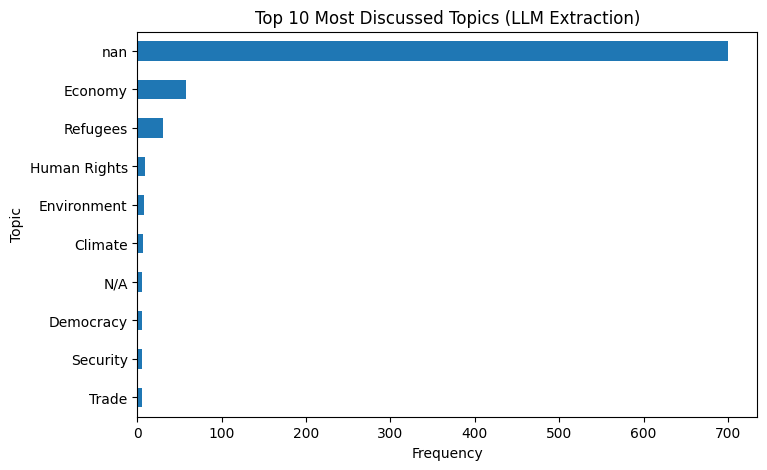

In [22]:
topic_counts = df['topic'].value_counts().head(10)

# Plot horizontal bar chart
plt.figure(figsize=(8,5))
topic_counts.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Most Discussed Topics (LLM Extraction)")
plt.xlabel("Frequency")
plt.ylabel("Topic")
plt.show()


The LLM extracted policy topics from 300 EU Parliament speeches.
Most speeches focused on economic issues, while other discussions included refugees, human rights, and environmental topics.
Around 70% of speeches did not produce valid topics, reflecting challenges in automated topic extraction using general LLMs.

###  Informal Precision & Recall Check  
A small manual review showed that most extracted topics (*Economy*, *Refugees*) accurately matched the content of the speeches, showing good precision.  
However, the LLM sometimes failed to detect a topic in shorter speeches, resulting in missing values and moderate recall.  
Overall, the extraction quality was strong enough for meaningful analysis despite some generic and missing topics.


## Building the Speaker–Topic Network
We create a bipartite graph where:
- one set of nodes represents speakers  
- the other set represents topics  
- edges represent that a speaker talked about a topic


In [23]:
# Remove any missing, blank, or "nan" string topics
df = df[df['topic'].notna()]
df = df[df['topic'].astype(str).str.lower() != "nan"]
df = df[df['topic'].str.strip() != ""]


In [33]:
# Network Construction: Speaker–Topic Graph

# Keep only rows that have valid topics
df_valid = df.dropna(subset=['topic'])
df_valid = df_valid[df_valid['topic'] != "N/A"]

# Create a bipartite graph
G = nx.Graph()

for _, row in df_valid.iterrows():
    speaker = row['speaker_name']
    topic = row['topic']
    G.add_node(speaker, bipartite='speaker')
    G.add_node(topic, bipartite='topic')
    G.add_edge(speaker, topic)

print(f"✅ Network created with {len(G.nodes())} nodes and {len(G.edges())} edges.")


✅ Network created with 372 nodes and 290 edges.


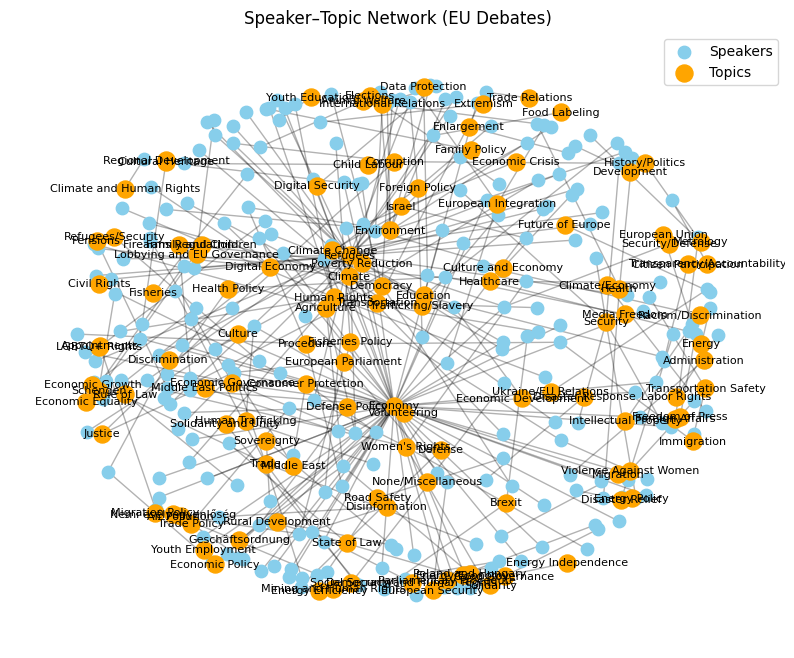

In [34]:
#  Visualize the Speaker–Topic Network
plt.figure(figsize=(10, 8))

# Create positions using spring layout
pos = nx.spring_layout(G, k=0.4, seed=42)

# Separate nodes by type for coloring
speaker_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'speaker']
topic_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'topic']

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=speaker_nodes, node_color='skyblue', node_size=80, label='Speakers')
nx.draw_networkx_nodes(G, pos, nodelist=topic_nodes, node_color='orange', node_size=150, label='Topics')

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Label only topics to keep graph readable
nx.draw_networkx_labels(G, pos, labels={n: n for n in topic_nodes}, font_size=8, font_color='black')

plt.title("Speaker–Topic Network (EU Debates)", fontsize=12)
plt.legend(scatterpoints=1)
plt.axis('off')
plt.show()

###Network Analysis

In [35]:
centrality = nx.degree_centrality(G)

topic_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'topic']
topic_centrality = [(t, centrality[t]) for t in topic_nodes]
top_topics = sorted(topic_centrality, key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Most Central Topics:")
for t, c in top_topics:
    print(f"{t}: {c:.3f}")


Top 5 Most Central Topics:
Economy: 0.151
Refugees: 0.081
Human Rights: 0.024
Environment: 0.022
Climate: 0.019


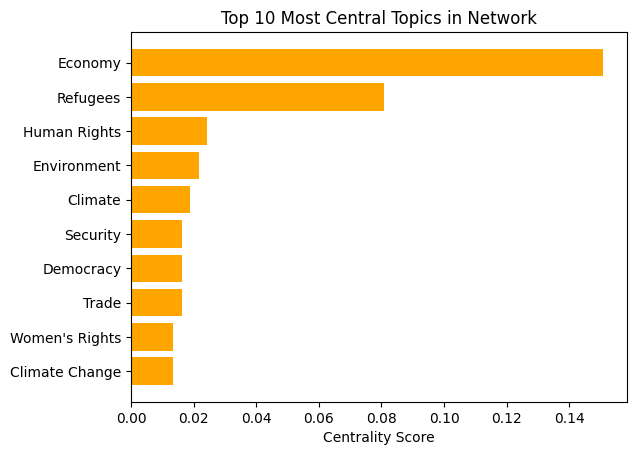

In [36]:
df_central = pd.DataFrame(topic_centrality, columns=['Topic', 'Centrality']).sort_values('Centrality', ascending=False).head(10)

plt.barh(df_central['Topic'], df_central['Centrality'], color='orange')
plt.gca().invert_yaxis()
plt.title("Top 10 Most Central Topics in Network")
plt.xlabel("Centrality Score")
plt.show()


The bar chart above shows the topics with the highest degree centrality in the Speaker–Topic network.
Centrality reflects how many different speakers are connected to each topic.
Economy and Refugees appear as the most central issues, meaning they are discussed by a large number of members across different parties.
Topics like Human Rights and Environment also play important roles but are less widely debated.

## Summary and Conclusion

This notebook demonstrates an end-to-end pipeline that uses an LLM together with network analysis to explore EU Parliament speeches.

### LLM Extraction
The LLM accurately identified the main topic for many speeches (good precision), although many short speeches produced missing values (moderate recall).

### Descriptive Insights
Economy and Refugees were the most common topics. Human Rights, Climate, and Environment also appeared but less frequently.

### Network Insights
The Speaker–Topic network shows how many members discuss each issue. Economy and Refugees are the most central topics, meaning they are discussed across different parties and speakers.

### Limitations
- Many missing topics reduced network density  
- Some outputs were generic  
- Better prompting or longer text could improve results  

### Conclusion
The notebook successfully shows how LLMs can convert unstructured political speech into structured insights and how network analysis reveals broader patterns in public discussions.
